In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Import data and create df

data = pd.read_csv("/Users/Stacy/Documents/WebDevelopment/projects/sexualAssault_datasets/2010-2018_sexcrimes_violentcrimes.csv", index_col="CAD Event Number")
data = pd.DataFrame(data)

In [4]:
# Rename columns to be pythonic

data.columns = ['event_clearing', 'call_type', 'priority', 
                'initial_call_type', 'final_call_type', 'original_time_queued',
               'arrived_time', 'precinct', 'sector', 'beat']

In [5]:
# ID all calls cancelled by dispatch
cancelled_calls = data[data.event_clearing.str.contains("CANCELLED")]

# Delete rows with cxl'd calls

data = data[data.event_clearing != 'RESPONDING UNIT(S) CANCELLED BY RADIO']
data = data[data.event_clearing != 'DUPLICATED OR CANCELLED BY RADIO']

#### Clean time values

In [6]:
# Change original_time_queued to datetime
data['original_time_queued'] = pd.to_datetime(data.original_time_queued)

# Change arrived_time to datetime
data['arrived_time'] = pd.to_datetime(data.arrived_time, format='%b %d %Y %I:%M:%S:%f%p')

# Add time delta between original_time_queued and arrived_time
data['time_delta'] = ((data.arrived_time - data.original_time_queued)/np.timedelta64(1, 's')).astype(int)

In [7]:
# Add columns for arrived year and month

data['year'] = data.arrived_time.dt.year
data['month'] = data.arrived_time.dt.month

# For rows with bad arrived time: change month and year to original_time_queued
# Where arrive_time year = 1900, change data.year and data.month to original_time_queued year

mask = data.year < 1901
column_name_year = 'year'
column_name_month = 'month'
data.loc[mask, column_name_year] = data.original_time_queued.dt.year
data.loc[mask, column_name_month] = data.original_time_queued.dt.month

#### Define terms

In [8]:
# Define TRU initial call types
TRU_call_types = [
    'TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS)',
    'TRU - RAPE',
    'TRU - LEWD CONDUCT',
    'TRU - CHILD ABUSED, NEGLECTED',
    'TRU - THREATS',
    'TRU - ROBBERY',
    'TRU - ASLT - MOLESTED ADULT (GROPED, FONDLED, ETC)',
    'TRU - HARASSMENT',
    'TRU - SEX IN PUBLIC',
    'TRU - THEFT',
    'TRU - FOLLOW UP',
    'TRU - MVC - HIT AND RUN',
    'TRU - LURING',
    'TRU - FORGERY/CHKS/BUNCO/SCAMS/ID THEFT',
    'TRU - SUSPICIOUS CIRCUMSTANCES']

In [9]:
# Define terms that ID which crime_type

# Define terms that ID rape CFS
rape_terms = 'STRANGER|ACQUAINTANCE'
rape_call_types = [
    '--RAPE - KNOWN SUSPECT (ACQUAINTANCE)',
    '--RAPE - UNKNOWN SUSPECT (STRANGER)']

# Define terms that ID sex crimes
sex_crime_terms = 'CSEC|LEWD|MOLESTING|STRANGER|ACQUAINTANCE'
sex_crime_call_types = [
    '--SEX OFFENSES (NON-RAPE) - LEWD CONDUCT',
    '--RAPE - KNOWN SUSPECT (ACQUAINTANCE)',
    '--RAPE - UNKNOWN SUSPECT (STRANGER)',
    '--SEX OFFENSES (RAPE) - MOLESTING',
    '--COMMERCIAL SEXUAL EXPLOITATION OF MINORS (CSEC)']

# Define terms that ID other violent crimes
violent_crime_terms = 'KIDNAP|HOMICIDE|SHOOTING|ASSAULTS|ROBBERY'
violent_crime_call_types = [
    '--ASSAULTS - FIREARM INVOLVED',
    '--ROBBERY - ARMED',
    '--HOMICIDE',
    '--KIDNAP - GENERAL',
    '--DRIVE BY SHOOTING - NO INJURIES']

In [10]:
# ID clearing codes for is_arrest

arrest_cc = ['PHYSICAL ARREST MADE']

### Add columns for is_arrest, is_TRU, and crime_type

In [70]:
# Add column identifying if there was an arrest
data['is_arrest'] = np.where(data['event_clearing'].isin(arrest_cc), 'yes', 'no')

# Add column identifying if this was A TRU call
data['is_TRU'] = np.where(data['initial_call_type'].isin(TRU_call_types), 'yes', 'no')

# Add column identifying crime type
data['crime_type'] = np.where(data['final_call_type'].isin(sex_crime_call_types), 'sex crime', 'violent crime')

### 1. 2018 Sees increase in reports of sex crimes
In the same time period, Seattle saw a decrease in the reporting of other violent crimes.

In [25]:
# Delete I think

# Create df that labels each call type as a violent crime, sex crime, or rape
is_rape = data['final_call_type'].str.contains(rape_terms)
is_vc = data['final_call_type'].str.contains(violent_crime_terms)
is_sex_crime = data['final_call_type'].str.contains(sex_crime_terms)


temp_df = data[is_rape | is_vc | is_sex_crime]
#temp_df['crime_type'] = np.where(temp_df['final_call_type'].isin(sex_crime_call_types), 'sex crime', 'violent crime')
temp_df['crime_type'] = np.where(temp_df['final_call_type'].isin(rape_call_types), 'rape',
                                (np.where(temp_df['final_call_type'].isin(sex_crime_call_types), 'non-rape sex crime', 'violent crime')))

In [28]:
# Add crime_type for each call type as a violent crime, sex crime, or rape
is_rape = data['final_call_type'].str.contains(rape_terms)
is_vc = data['final_call_type'].str.contains(violent_crime_terms)
is_sex_crime = data['final_call_type'].str.contains(sex_crime_terms)
is_lewd_conduct = data['final_call_type'].str.contains("LEWD")

data['crime_type'] = np.where(data['final_call_type'].isin(rape_call_types), 'rape',
                                (np.where(data['final_call_type'].isin(sex_crime_call_types), 'non-rape sex crime', 'violent crime')))

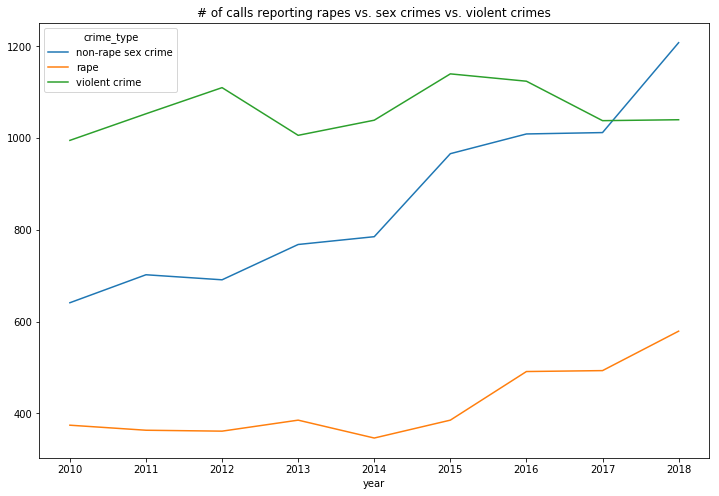

In [30]:
# Compare number of rape calls, non-rape sex crime calls, and violent crime calls by year

data.groupby('crime_type').year.value_counts().unstack(0).plot.line(stacked=False, figsize=(12,8), title="# of calls reporting rapes vs. sex crimes vs. violent crimes")

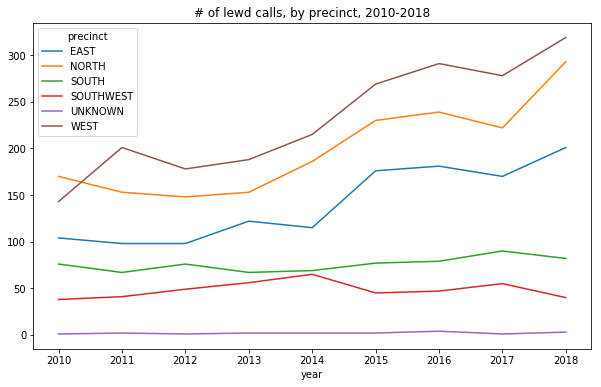

In [34]:
# Plot lewd conduct calls, by precinct, over the years
lewd_df = data[is_lewd_conduct]

lewd_df.groupby('precinct').year.value_counts().unstack(0).plot.line(stacked=False, figsize=(10,6), title="# of lewd calls, by precinct, 2010-2018")


In [24]:
# Delete?

# All sexual assaults by year (upwards trend)
pd.value_counts(is_violent_crime.year).reindex([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]).plot.bar()


NameError: name 'is_violent_crime' is not defined

In [ ]:
# year by year violent crime

is_violent_crime = data['final_call_type'].str.contains(violent_crime_terms)
stage_is_violent_crime = data[is_violent_crime]


